## Motivation

In the experiment designed to test the independency of cell fate decisions in the ICM (see main text and Figure 1), we mix wild type embyro cells labelled with H2B-GFP and unlabelled cells (either wild type or Gata6 null). The presence (or absence) of GFP lets us identify the progeny of each subpopulation (GFP+, GFP-). 
Given that either population can represent any given fraction of the resulting chimeric embryo, manual scoring of GFP+ and GFP- cells becomes unreasonable, and therefore we automated the task. GFP expression is variable due to mosaic expression of the transgene and to the noise in the image acquisition and  processing. For these reasons a simple threshold is not enough to accurately separate populations. Instead, we use clustering methods, which give a better result.  

In this notebook, I compare the performance of three approaches, Hierarchical clustering, 1D and 2D K-means clustering, and show the rationale for the approach we ultimately used in the study.

### Set up
Load necessary packages and create an object with plotting aesthetics

In [2]:
library('reshape2')
library('plyr')
library('dplyr')
library('ggplot2')

looks <- theme_bw() + theme(panel.grid = element_blank(), 
                            strip.background = element_blank(), 
                            panel.border = element_rect(color = 'black', 
                                                        size = 1), 
                            axis.ticks = element_line(color = 'black', 
                                                      size = 0.5), 
                            axis.text = element_text(size = 6, 
                                                     color = 'black'), 
                            axis.title = element_text(size = 8, 
                                                      color = 'black'), 
                            legend.text = element_text(size = 8, 
                                                       color = 'black'), 
                            legend.title = element_text(size = 10, 
                                                        color = 'black'), 
                            strip.text = element_text(size = 8, 
                                                      color = 'black'))


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


### Load data

Read in transformed and corrected data for the chimeras experiments

In [3]:
g6.chimeras <- read.csv('../data/processed/emb-xim-processed.csv')

### First look  

Let's first generate a plot showing the distribution of GFP levels for all embryos at the end of the experiment (after 48h in culture). Below we will plot some density distributions showing GFP levels on the X axis, one curve for each embryo. Embryos are grouped by litter and treatment: 
   * **control** embryos (100% cells either GFP+ or GFP-) are shown as black lines 
   * **chimeric** embryos (different fractions of GFP+ and GFP- cells) are shown as green lines

Each panel is labeled with letters indicating the litter and a number that indicates the initial % of GFP+ cells at the time of making the chimera.

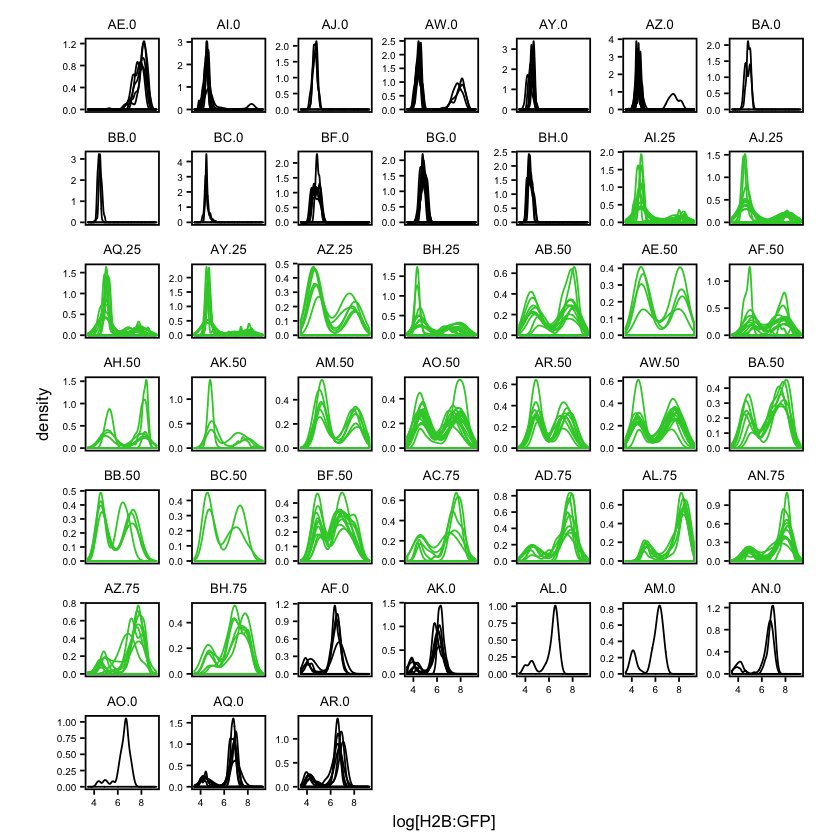

In [3]:
curves <- ggplot(data = g6.chimeras %>% filter(Channel == 'CH2', 
                                               CH2.ab2 == 'af488.ck'))
for(e in unique(g6.chimeras$Embryo_ID)){
        curves <- curves + geom_density(data = g6.chimeras %>%
                                                filter(Treatment == 'Chimera',
                                                       Channel == 'CH2',
                                                       Embryo_ID == e),
                                        aes(x = CH2.logCor),
                                        color = '#33cc33', alpha = 0.5)
        curves <- curves + geom_density(data = g6.chimeras %>%
                                                filter(Treatment == 'Control',
                                                       Channel == 'CH2',
                                                       Embryo_ID == e),
                                        aes(x =  CH2.logCor),
                                        color = 'black', alpha = 0.5)
}
curves <- curves + looks + theme(aspect.ratio = 1, 
                                 strip.text = element_text(size = 8), 
                                 axis.text = element_text(size = 6), 
                                 axis.title = element_text(size = 10))
curves <- curves + labs(x = 'log[H2B:GFP]')
curves <- curves + facet_wrap( ~ reorder(interaction(Litter, t0.donor), 
                                         t0.donor), scales = 'free_y')
print(curves)

As one might expect, chimeras show bimodal distributions of GFP levels, corresponding to GFP- and GFP+ cells, and the height of the peaks roughly agrees with the initial fraction of GFP- and GFP+ cells in the group (for instance, compare AR.50, which had 50% GFP+, 50% GFP- at the start, with AL.75, which had 25% GFP- and 75% GFP+ at the start).

### Uncertainty

Given the bimodal distribution we could just split both peaks using clustering along one dimension (H2B-GFP levels). However, for most embryos, it is not a clean division - there is always a fraction of cells with intermediate GFP levels. This becomes quite obvious if we plot embryos separately for one given litter:

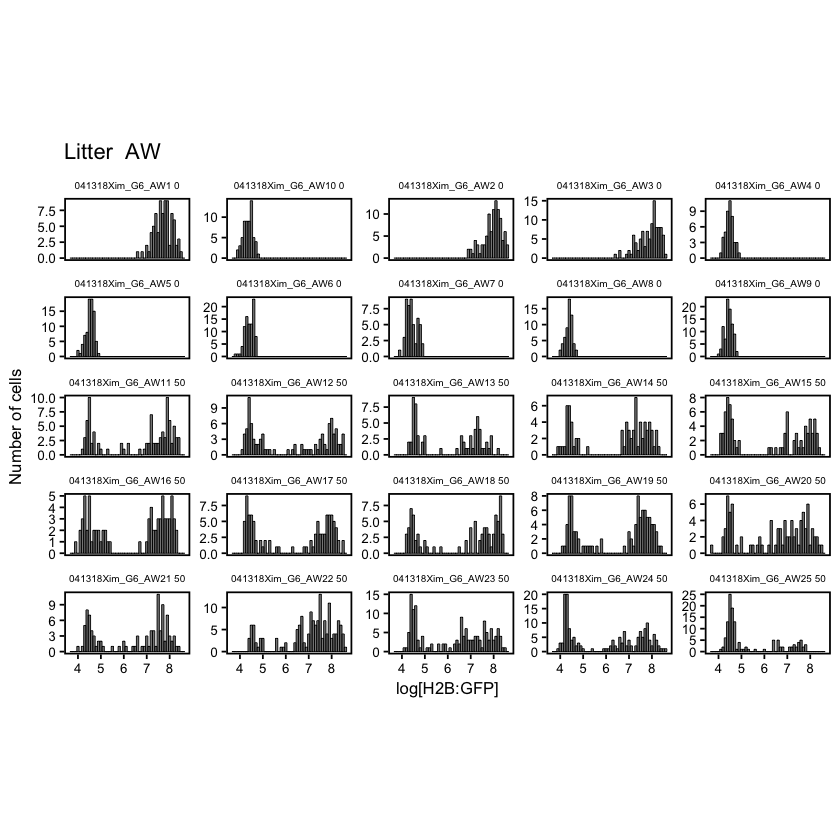

In [6]:
# Choose an example litter
my.litter <- 'AW'

# Plot histogram
histos <- ggplot(data = g6.chimeras %>% 
                 filter(Litter == my.litter,
                        Channel == 'CH2', 
                        CH2.ab2 == 'af488.ck'),
                 aes(x = CH2.logCor))
        histos <- histos + geom_histogram(color = 'black', binwidth = 0.1, 
                                          alpha = 0.75, size = 0.25)
        histos <- histos + looks 
        histos <- histos + labs(x = 'log[H2B:GFP]', y = 'Number of cells', 
                                title = paste('Litter ', my.litter))
        histos <- histos + facet_wrap( ~ reorder(paste(Embryo_ID, t0.donor), 
                                      t0.donor), scales = 'free_y')
        histos <- histos + theme(aspect.ratio = 1/2, 
                                 strip.text = element_text(size = 6), 
                                 axis.text = element_text(size = 8), 
                                 axis.title = element_text(size = 10))
        print(histos)

While in some chimeras (AW14, AW15) the separation between GFP+ and GFP- is very evident, for others, like AW20, or AW23, there are a few cells with intermediate levels.  

This is an error we can live with for chimeras in which both subpopulations are wild type. However, this can be problematic in chimeras where the GFP- cells are *Gata6-/-*. In those experiments, GFP+ cells (wild type) erroneously classified as GFP- (*Gata6* null) could be Primitive Endoderm, a cell type *Gata6-/-* cannot make. Therefore, it is worth to try and get the best classification possible (spoiler: *it won't be perfect...*).  

Let's then better separate cells introducing a second dimension, like the nuclear label we use, Hoechst:

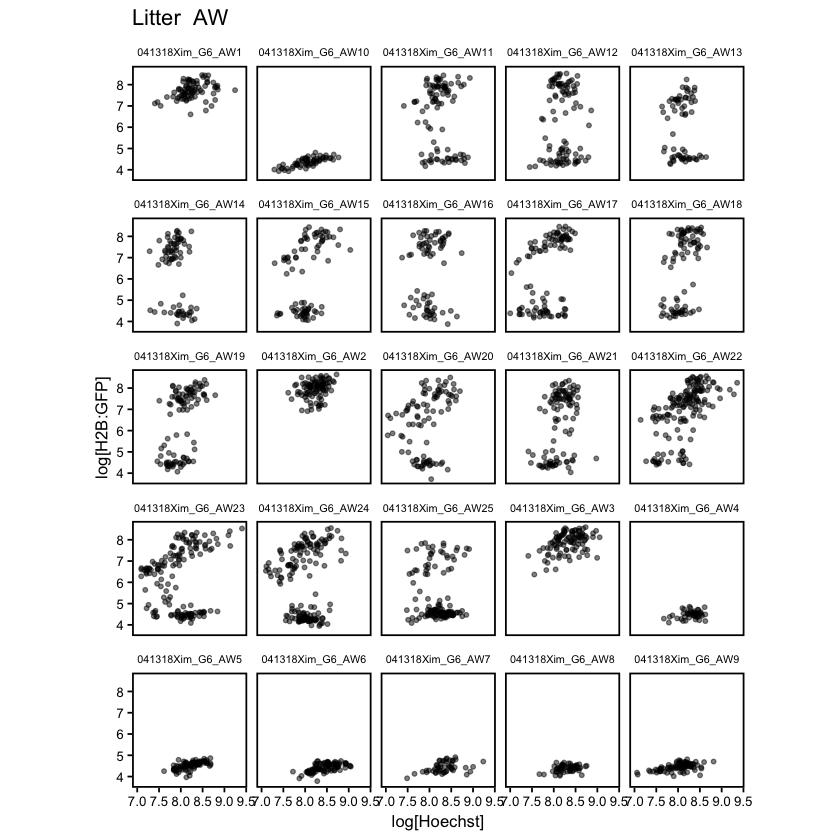

In [15]:
scatter <- ggplot(data = g6.chimeras %>% 
                 filter(Litter == my.litter,  
                        Channel == 'CH2', 
                        CH2.ab2 == 'af488.ck'), 
                  aes(x = CH1.ebLogCor, 
                      y = CH2.logCor))
scatter <- scatter + geom_jitter(size = 1, alpha = 0.5)
scatter <- scatter + facet_wrap( ~ Embryo_ID)
scatter <- scatter + looks + theme(aspect.ratio = 1, 
                                 strip.text = element_text(size = 6.5), 
                                 axis.text = element_text(size = 8), 
                                 axis.title = element_text(size = 10))
scatter <- scatter + labs(y = 'log[H2B:GFP]', x = 'log[Hoechst]', 
                                title = paste('Litter ', my.litter))
print(scatter)

Now, it is easier to tell where the intermediate cells belong, at least for some embryos (like AW18 or 19).

### K-means clustering  

Let's try to separate the two clusters in chimeras using K-means clustering. In control embryos there is no need to classify, as all cells are the same. In order to have robust clustering, we will run the algorithm on each litter (experiment) separately, but for all embryos in one litter together. Each litter was processed and imaged at once, therefore most variation within each litter should be biological, whereas variation between litters can be technical to a fair degree.  

In [27]:
# Split dataset into Control embryos (100% host) and chimeras (mix)
cc <- subset(g6.chimeras, Treatment == 'Control')
xs <- subset(g6.chimeras, Treatment == 'Chimera')

# Classify all control cells as 'host'
cc$cell_type <- 'host'

In [28]:
# Split xs by litter and store into a list
xs <- split(xs, as.factor(xs$Litter))

In [29]:
# Loop through the list of chimeras
for(l in 1:3) {
    # Select only CH1 (Hoechst) and CH2 (GFP) to do clustering
    bb <- xs[[l]] %>% select(Cellcount, 
                     CH1.ebLogCor, CH2.logCor)
    # Run K-means, looking for 2 clusters
    kk <- kmeans(bb[, 2:3], 2)
    print(kk$centers)
}

  CH1.ebLogCor CH2.logCor
1     7.801132   7.783898
2     7.722305   4.783361
  CH1.ebLogCor CH2.logCor
1     7.771743    7.49706
2     7.739588    4.72219
  CH1.ebLogCor CH2.logCor
1     7.716554   4.805525
2     7.690431   7.632297


In [ ]:
# Calculate the sum of squares of the difference between 
    # values and cluster centers
    ssq <- matrix(0, length(xs[[l]]$TE_ICM), 2)
    for(i in 1:2) {
        ssq[,i] <- (xs[[l]]$CH1.ebLogCor - kk$centers[i,1])^2 +
                (xs[[l]]$CH2.logCor - kk$centers[i,2])^2
    }
    min.ssq <- apply(ssq, 1, which.min)
    # Classify cells as 'donor' (GFP+) or 'host' (GFP-)
    xs[[l]]$cell_type.km <- rep(NA, nrow(xs))
    xs[[l]]$cell_type.km <- c('donor', 'host')[min.ssq]